# Optimising Returns in Portfolio Management

### Exploring Numerical Optimisation Techniques to solve Quadratic Problems in Python

##### Zac Keskin - Numerical Optimisation - UCL 2018

 ## Part 0:  Define functions, Import Data

### Pre-import required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

### First, we prepare line-search functions for the optimisation routines
The backtracking algorithm provides the simplest working implementation for calculating suitable step-length sizes in line-search routines, so this is the function used throughout. The linesearch/zoom implementation finds step lengths satisfying the strong Wolfe conditions, are is shown only for comparison.

In [2]:
# Backtracking algorithm to find alpha satisfying sufficient decrease condition
def backtracking(func, jac, x_k, p_k, alpha_max=1, c1 = 1e-4, maxiter=25):
    
    # Define parameters
    rho = 0.9
    alpha = alpha_max; 
    k=0

    #Compute f, grad f at x_k
    f_k = func(x_k)
    df_k = jac(x_k)

    # Backtracking linesearch for computing step length
    while func(x_k + alpha*p_k) > ( f_k + c1 * alpha * np.dot(df_k,p_k) ) and k < maxiter:
        alpha = rho*alpha
        k+=1
    
    return alpha


In [3]:
# Algorithm 3.5 from Nocedal & Wright 
def linesearch(func, jac, x_k, p_k, alpha_max=1, c1 = 0.0001, c2=0.1, maxIter=25):
    
    alphas = [0, 0.9*alpha_max]
    i = 1

    while i < maxIter:
        
        # Calculate required terms
        phi_i = phi(func,x_k,p_k,alphas[i])
        phi_i_1 = phi(func,x_k,p_k,alphas[i-1])
        phi_prime_0 = der_phi(jac,x_k,p_k, 0)
        phi_0 = phi(func,x_k,p_k, 0) + c1 * alphas[i] * phi_prime_0
        
        if phi_i > phi_0 or (phi_i >= phi_i_1 and i > 1):
            a_star = zoom(alphas[i-1],alphas[i],func, jac, x_k, p_k, c1, c2)
            #print('Linesearch found alpha*: ', a_star)
            return a_star
        phi_prime_i = der_phi(jac,x_k,p_k, alphas[i])
        
        if abs(phi_prime_i) <= -c2*phi_prime_0:
            a_star = alphas[i]
            #print('Linesearch found alpha*: ', a_star)
            return a_star

        if phi_prime_i >= 0:
            a_star = zoom(alphas[i],alphas[i-1],func, jac, x_k, p_k, c1, c2)
            #print('Linesearch found alpha*: ', a_star)
            return a_star

        # Update alpha_i and go again
        alphas.append(min(2*alphas[i], alpha_max))
        i+=1

    print("linesearch failed to converge")
    return 0 # If convergence fails

In [4]:
# Algorithm 3.6 from Nocedal & Wright (Not Working)
def zoom(alpha_lo, alpha_hi, func, jac, x_k, p_k, c1, c2, maxIter=10, tol = 1e-8):
    if alpha_lo > alpha_hi:
        temp = alpha_lo
        alpha_lo = alpha_hi 
        alpha_hi = temp
    j=0
    while j < maxIter:
        alpha_j = (alpha_hi + alpha_lo)/2

        # Calculate required terms
        phi_j = phi(func,x_k,p_k,alpha_j)
        phi_prime_0 = der_phi(jac, x_k, p_k, 0)
        phi_0 = phi(func,x_k,p_k, 0) 
        phi_lo = phi(func,x_k,p_k,alpha_lo)

        if abs(alpha_hi - alpha_lo) < tol:
            return alpha_j
            print('Line search stopped because the interval became to small. Return alpha_j.')

        if phi_j > (phi_0 + c1 * alpha_j * phi_prime_0) or phi_j >= phi_lo:
            alpha_hi = alpha_j
        else:
            # alpha_j satisfies sufficient decrease condition
            phi_prime_j = der_phi(jac, x_k, p_k, alpha_j)
            
            if abs(phi_prime_j) <= -c2*phi_prime_0:
                # alpha_j satisfies strong curvature condition
                return alpha_j

            if phi_prime_j * (alpha_hi - alpha_lo) >= 0:
                alpha_hi = alpha_lo
            
            alpha_lo = alpha_j
        j+=1
    print("zoom failed to converge")
    return alpha_j # If convergence fails

### Now, we define optimisation routines. Three different techniques are included:

In [5]:
# Steepest Gradient Descent
def SGD(x0, func, jac, hess=None, alpha0=1, tol=1e-6, maxiter=1e4):
    x = np.array(x0).reshape(1,len(x0))
    f = func(x0)
    k = 0
    es = np.linalg.norm(jac(x0))

    stop = False
    while stop==False and k < maxiter:
        p_k = -jac(x[k]) # Descent direction
        
        alpha = backtracking(func,jac,x[k],p_k)

        x = np.vstack((x, x[k] + alpha * p_k))
        k=k+1
        f = np.vstack((f, func(x[k])))
        
        stop = (np.linalg.norm(jac(x[k])) < tol*(1 + tol * abs(func(x[k]))))
        es = np.vstack((es, np.linalg.norm(jac(x[k])) ))

    res = opt_result(x,k,f,es)
    return res

In [6]:
# Newton
def Newton(x0, func, jac, hess, alpha0=1, tol=1e-6, maxiter=1e3):
    N = len(x0)
    x = np.array(x0).reshape(1,N)
    f = func(x0)
    es = np.linalg.norm(jac(x0)) 
    k = 0
    

    stop = False
    while stop == False and k < maxiter:
        H_k = np.linalg.inv(hess(x[k]))  # Descent direction
        p_k = - np.dot(H_k,jac(x[k]))

        # Force to be descent direction (in case Hess is no longer SPD due to penalty terms)
        if np.dot(p_k, jac(x[k])) > 0: 
            p_k = -p_k
        
        alpha = backtracking(func, jac, x[k], p_k)
        
        x = np.vstack((x, x[k] + alpha * p_k))
        k=k+1
        f = np.vstack((f,func(x[k])))

        stop = (np.linalg.norm(jac(x[k])) < tol*(1 + tol * abs(func(x[k]))))
        es = np.vstack((es, np.linalg.norm(jac(x[k])) ))

    res = opt_result(x,k,f,es)
    return res

In [7]:
# BFGS
def BFGS(x0, func, jac, hess=None, alpha0=1, tol=1e-6, maxiter=1e3):
    # Algorithm 6.1 from Nocedal & Wright
    N = len(x0)
    x = np.array(x0).reshape(1,N)
    f = func(x0)
    es = np.linalg.norm(jac(x0))

    k = 0
    I = np.eye(N, dtype=int)
    H_k = I 

    stop = False
    while stop==False and k < maxiter:
        # Step direction p_k
        p_k = - np.matmul(H_k, jac(x[k]))


        # Find Step length alpha
        alpha = backtracking(func, jac, x[k], p_k) 

        # Update x_k, f(x_k)
        x = np.vstack((x, x[k] + alpha * p_k))
        k=k+1
        f = np.vstack((f, func(x[k])))

        # Careful to enforce 1D vector shape, or np.matmul and np.dot do not behave as expected
        s_k = (x[k] - x[k-1]).reshape(N,1)
        y_k = (jac(x[k]) - jac(x[k-1]) ).reshape(N,1)   
        rho_k = 1/np.dot(y_k.transpose(), s_k)

        if k == 1:
            # Update initial guess H_0.
            H_k = H_k * np.matmul(s_k.transpose(),y_k) / np.matmul(y_k.transpose(),y_k)
        
        # Update H_k using 6.17 from Nocedal & Wright
        H_k_1 = H_k
        
        A1 = I - rho_k * np.matmul(s_k,y_k.transpose())
        A2 = I - rho_k * np.matmul(y_k,s_k.transpose())
        H_k = np.matmul( A1, np.matmul(H_k_1, A2)) + rho_k * np.matmul(s_k,s_k.transpose())

        stop = (np.linalg.norm(jac(x[k])) < tol*(1 + tol * abs(func(x[k]))))
        es = np.vstack((es, np.linalg.norm(jac(x[k])) ))
        
    res = opt_result(x,k,f,es)
    return res 

In [8]:
# And a wrapper class to store and return iteration info in a consistent manner
class opt_result():
    def __init__(self, x, k, f, errors):
        self.xs = x
        self.fs = f
        self.k = k
        self.fun = self.fs[k]
        self.x = self.xs[k]
        self.es = errors


### Import Prepared Data
Prepared 6-Months' data on daily log-returns and variance, from twenty 'FTSE100' stocks selected at random

In [9]:
# Import data
fname = 'returns.csv'
DF = pd.read_csv(fname)
N = 5   # Number of stocks to use
DF = DF.loc[:,DF.columns.str.endswith('returns')]
DF = DF.iloc[:,:N]

In [10]:
# Calculate average returns for each asset
Mus = np.array(DF.mean(axis=0)) # Get np vector for average daily log-returns per stock
print(Mus)

[ 0.00250784 -0.00136806  0.00279892 -0.00065287  0.00011025]


### Define Objective Function (with penalty terms)
And Gradient and Hessian functions, determined analytically

In [11]:
def objective_plus_penalty(W):
    Q = DF.cov()                                  # Covariance matrix
    var = np.matmul(W.transpose(),np.matmul(Q,W)) # Variance vector

    # Penalty Function method
    penalty1 =  (np.sum(W)-1)**2                    # Large for sum(x) <> 1
    penalty2 =  100* (R_min - np.matmul(Mus.transpose(), W))**2  # Large for returns <> minR
    return var + penalty1 + penalty2

def der_objective_plus_penalty(W):
    Q = DF.cov()

    der = 2 * np.matmul(Q,W)

    penalty1_der = np.array([2*np.sum(W)-2 for i,Wi in enumerate(W)])
    penalty2_der = 100*np.array([ 2*Mus[i] * (np.matmul(Mus.transpose(),W) - R_min) for i,Wi in enumerate(W)])

    return der + penalty1_der + penalty2_der

def hess_objective_plus_penalty(W):
    Q = DF.cov()
    hess = 2 * Q.values

    # Assemble Hessian terms for penalty1 function
    penalty1_hess = 2*np.ones_like(hess)

    # Assemble Hessian terms for penalty2 function
    bcast = np.broadcast(Mus.reshape(len(Mus),1),Mus.reshape(1,len(Mus)))
    penalty2_hess = np.empty(bcast.shape)
    penalty2_hess.flat = 100*np.array([2*a*b for (a,b) in bcast])
    
    return hess + penalty1_hess + penalty2_hess

# Part 1:  Calculate Efficient Frontier of Minimum-Variance Portfolios
We adjust the allocation of assets in the portfolio to minimise the volatility for a given expected rate of return.
By performing this minimisation routine for multiple values of R_min, we can trace out the 'Efficient Frontier' - the set of feasible optimal portfolios.

In [12]:
# Prepare lists awaiting results for plotting, using different optimisation algorithms
my_means=[]
my_vars=[]

In [13]:
# Define an initial allocation of resources
    # We use an equal allocation, but optima are found quickly even with difficult initial conditions
    #(e.g. unbalanced, large and/or negative allocations)
x0 = np.array([1/N for n in range(N)]) 


In [14]:

# Minimise Portfolio Variance at expected risk level

for R_min in np.linspace(-0.001,0.003,12):
    my_result = Newton(x0, objective_plus_penalty, der_objective_plus_penalty, hess_objective_plus_penalty, tol = 1e-6, maxiter=1e4)
    
    # Console Output
    """
    print('\n\n Return: ',R_min)
    print('n_iters: ', my_result.k)
    print('Portfolio Weight:', np.sum(my_result.x))
    """
    # Store results for plotting (variance minus penalty terms)
    my_means.append(np.dot(Mus,my_result.x)) 
    my_vars.append(my_result.fun - (np.sum(my_result.x)-1)**2 - 100*(R_min - np.matmul(Mus.transpose(), my_result.x))**2 )

print("Optimal Portfolio Values stored")

Optimal Portfolio Values stored


### Perform Monte Carlo Simulation of Portfolios
We generate portfolios with random allocations between N assets, and calculate the expected mean returns and variance. This provides context and reassures us of the validity of the optimisation routines (see figures below)

In [15]:
def rand_weights(n):
    # Produces n random weights that sum to 1
    W = np.random.rand(n)
    W = np.asmatrix(W/ np.sum(W)).reshape(len(Mus),1)
    return W

def return_portfolio(W):
    Q = np.asmatrix(DF.cov())       # Covariance matrix
    R = Mus.transpose() * W         # Expected Return of the portfolio
    Var = W.transpose() * Q * W     # Expected Variance of the portfolio
    return R, Var

In [16]:
n_portfolios = 1000 * N

mc_means = np.matrix(np.empty(1))
mc_vars = np.matrix(np.empty(1))

for portfolio in range(n_portfolios):
    W = rand_weights(len(Mus))
    m, s = return_portfolio(W)
    mc_means = np.vstack((mc_means,m))
    mc_vars = np.vstack((mc_vars, s))

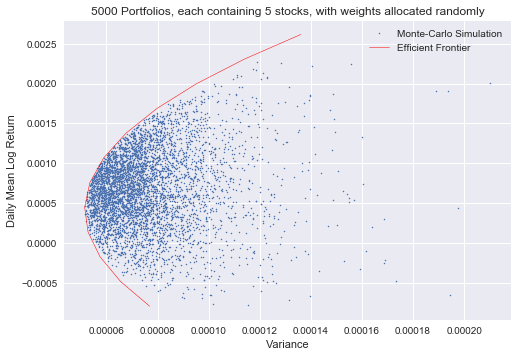

In [17]:
######################################################
# Plot Solutions on Mean-Variance Axis

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Plot Simulation
plt.plot(mc_vars[2:], mc_means[2:], 'o', markersize=1.5)
plt.xlabel('Variance')
plt.ylabel('Daily Mean Log Return')
plt.title(str(n_portfolios) + ' Portfolios, each containing ' + str(N) 
                            + ' stocks, with weights allocated randomly')

# Plot Efficient Frontier
plt.plot(my_vars,my_means,'r',linewidth=0.5) 
plt.legend(['Monte-Carlo Simulation','Efficient Frontier'])

# Part 2:  Compare Performance of Optimisation Algorithms under Penalty Methods
This is most neatly visualised using a trajectory plot over a 2D surface (corresponding to the simplified case of a two-asset portfolio)

First we reset initial conditions to the 2D case

In [18]:
# Initial condition (chosen outside the feasible set to display iteration more interestingly

# Reset Data
fname = 'returns.csv'
DF = pd.read_csv(fname)
N = 2   # Number of stocks to use
DF = DF.loc[:,DF.columns.str.endswith('returns')]
DF = DF.iloc[:,:N]

R_min = 0.001

Mus = np.array(DF.mean(axis=0)) 
x0 = np.array([-0.2 for n in range(N)])


### Define 2D Function Spaces
We wish to interrogate the possible combinations of assets in the portfolio. For two assets, this presents a space defined by the funds allocated to asset $x_1$ and asset $x_2$

In [19]:
### We define different spaces purely to better present the behaviour of the minimisation algorithms in each case

# No Penalty
x1 = np.linspace(-0.25,0.25,24)
x2 = np.linspace(-0.25,0.25,24)
f1_space = np.meshgrid(x1,x2)

# Penalty
x1 = np.linspace(-1.5,1.5,24)
x2 = np.linspace(-1.5,1.5,24)
f2_space = np.meshgrid(x1,x2)


### Define 2D Objective Functions 
We need to provide 2D scalar functions, with and without penalty terms, to plot and compare the two surfaces

In [20]:
# Objective function in 2D to operate over np meshgrid surfaces
def Var(x1,x2):
    W = np.array([x1,x2])
    Q = DF.cov().values

    Var = Q[0][0] * x1*x1 + Q[0][1] * x1*x2 + Q[1][0] * x2*x1 + Q[1][1] * x2*x2
    return Var

In [21]:
def Var_plus_penalty(x1,x2):
    W = np.array([x1,x2])
    Q = DF.cov().values
    Var = Q[0][0] * x1*x1 + Q[0][1] * x1*x2 + Q[1][0] * x2*x1 + Q[1][1] * x2*x2
    
    penalty1 =  (W[0] + W[1] - 1)**2
    penalty2 = 100* ( R_min - Mus[0] * W[0] - Mus[1] * W[1]) **2
    

    return Var + penalty1 + penalty2

### Calculate Trajectories
We also wish to present the routes which the optimisation routines traverse in iterating towards the optimal portfolio weights. This can be plotted over the surfaces defined above.

We make use of the objective functions defined initially, but now also need to define penalty-free variants in order to present the trajectory over the penalty-free surface:

In [22]:
def objective(W):
    Q = DF.cov()                                  # Covariance matrix
    var = np.matmul(W.transpose(),np.matmul(Q,W)) # Variance vector
    return var

def der_objective(W):
    Q = DF.cov()
    der = 2 * np.matmul(Q,W)
    return der

def hess_objective(W):
    Q = DF.cov()
    hess = 2 * Q.values    
    return hess


In [23]:
# Optimise using Steepest Gradient Descent (VERY SLOW!)
#sgd_result = SGD(x0, objective, der_objective, hess_objective, tol = 1e-6, maxiter=1e4)
#penalty_sgd_result = SGD(x0, objective_plus_penalty, der_objective_plus_penalty, hess_objective_plus_penalty, tol = 1e-6, maxiter=1e4)

In [24]:
# Optimise using BFGS
bfgs_result = BFGS(x0, objective, der_objective, hess_objective, tol = 1e-6, maxiter=1e4)
penalty_bfgs_result = BFGS(x0, objective_plus_penalty, der_objective_plus_penalty, hess_objective_plus_penalty, tol = 1e-6, maxiter=1e4)

In [25]:
# Optimise using Newton
newton_result = Newton(x0, objective, der_objective, hess_objective, tol = 1e-6, maxiter=1e4)
penalty_newton_result = Newton(x0, objective_plus_penalty, der_objective_plus_penalty, hess_objective_plus_penalty, tol = 1e-6, maxiter=1e4)

### Plot Trajectories onto Previous Surface Axes
Pre-produced plots are also made available as .pdf files alongside this notebook.

<IPython.core.display.Javascript object>


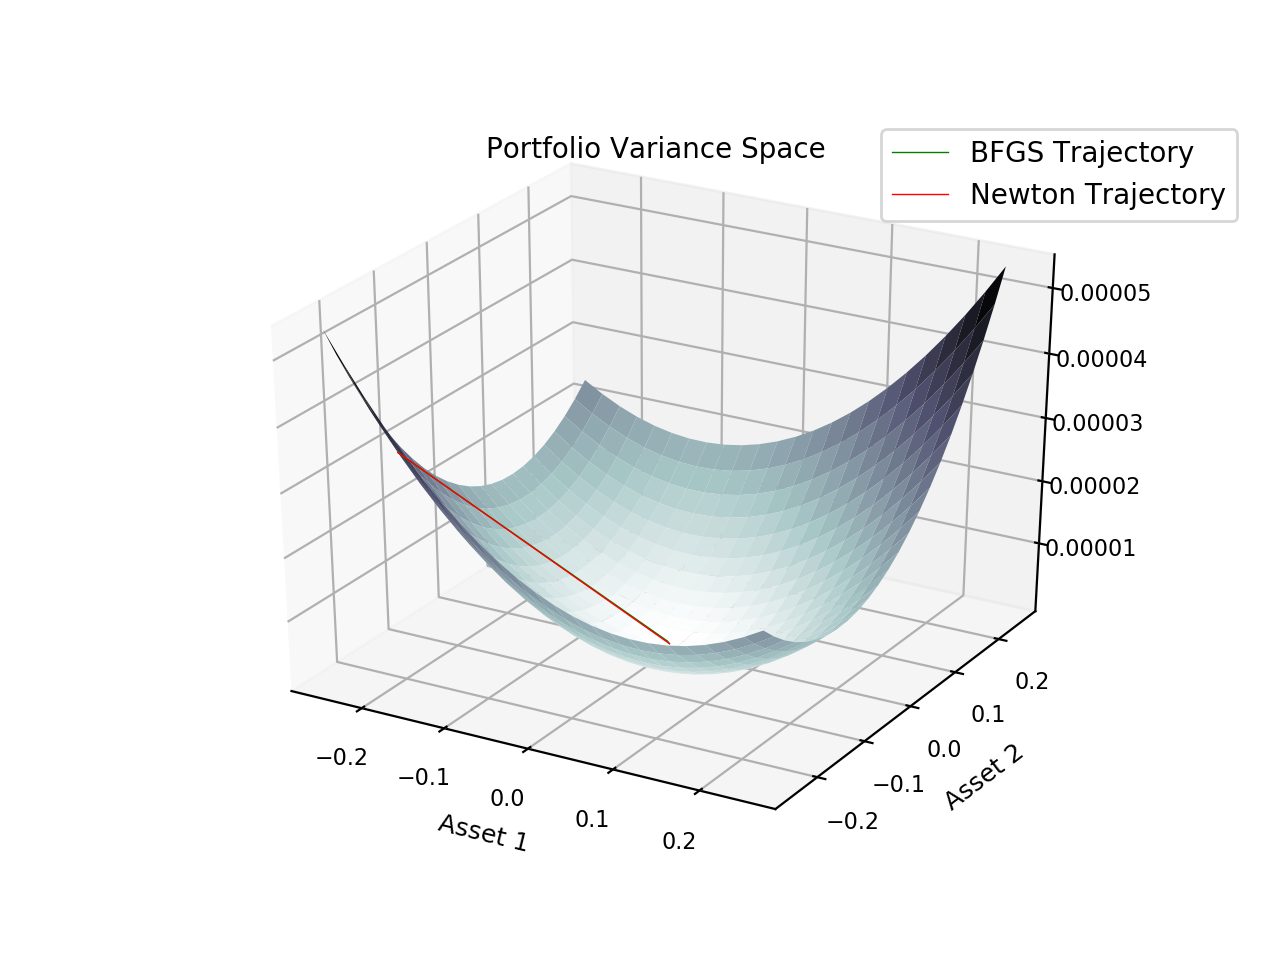

<IPython.core.display.Javascript object>


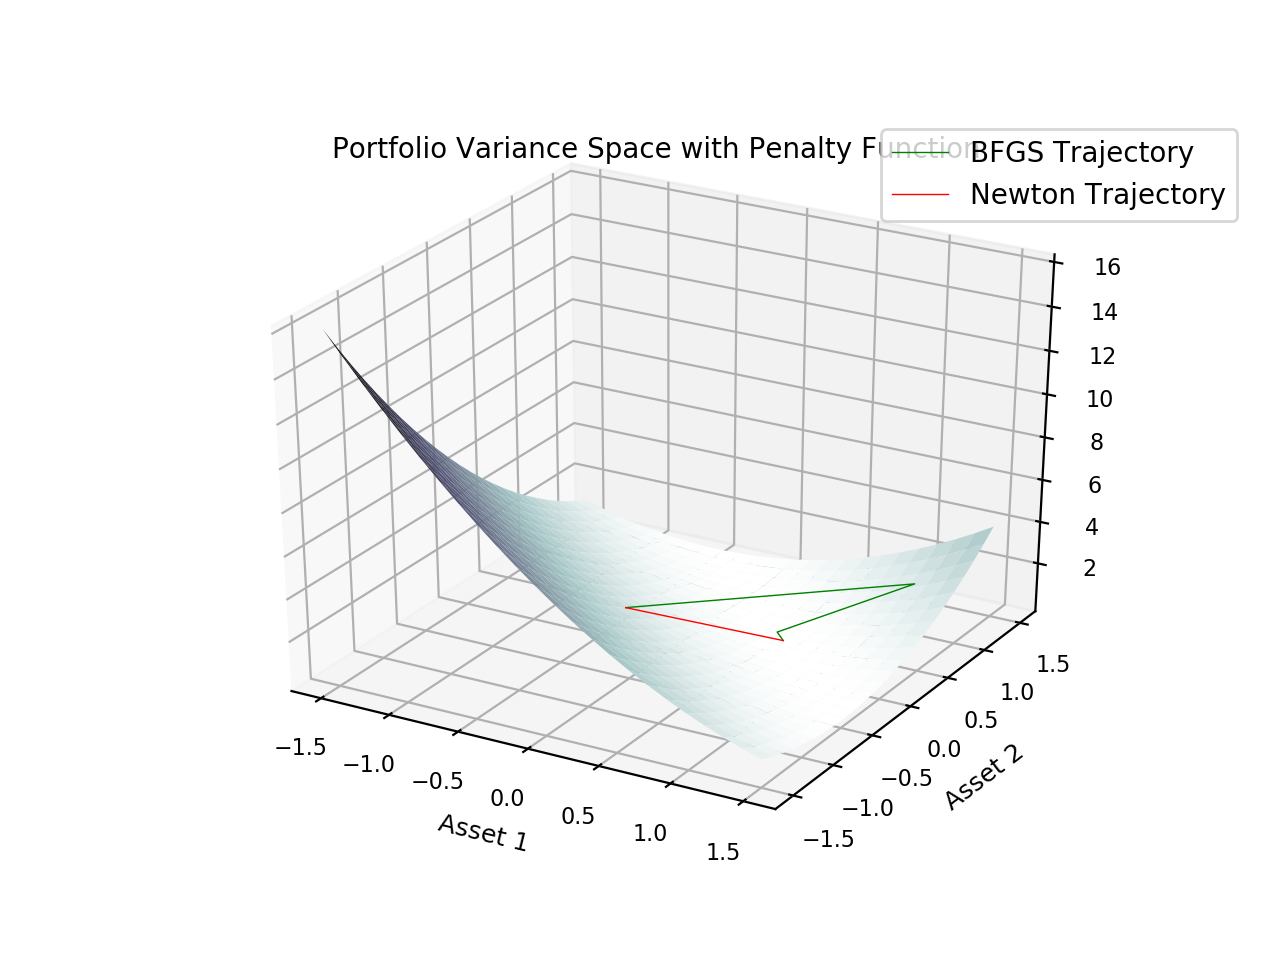

In [26]:
%matplotlib notebook
plt.style.use('default')

### Plot Surfaces

# No Penalty
Z1 = Var(f1_space[0],f1_space[1])  # Calculate the Variance over the feasible space

fig1 = plt.figure()
ax1 = fig1.gca(projection='3d')
ax1.plot_surface(f1_space[0],f1_space[1], Z1, cmap="bone_r")
ax1.set_title('Portfolio Variance Space')

# Including Penalty
Z2 = Var_plus_penalty(f2_space[0],f2_space[1]) # Calculate the Variance over the feasible space, with penalty terms

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.plot_surface(f2_space[0],f2_space[1], Z2, cmap="bone_r")
ax2.set_title('Portfolio Variance Space with Penalty Function')  



### Plot Trajectories

# No Penalty
ax1.plot(bfgs_result.xs[:,0], bfgs_result.xs[:,1], bfgs_result.fs.flatten(),'g',linewidth=0.5)
ax1.plot(newton_result.xs[:,0], newton_result.xs[:,1], newton_result.fs.flatten(),'r',linewidth=0.5)
#ax1.plot(sgd_result.xs[:,0], sgd_result.xs[:,1], sgd_result.fs.flatten(),'k',linewidth=0.5)

# Including Penalty
ax2.plot(penalty_bfgs_result.xs[:,0],penalty_bfgs_result.xs[:,1],penalty_bfgs_result.fs.flatten(),'g',linewidth=0.5)
ax2.plot(penalty_newton_result.xs[:,0], penalty_newton_result.xs[:,1], penalty_newton_result.fs.flatten(),'r',linewidth=0.5)
#ax2.plot(penalty_sgd_result.xs[:,0], penalty_sgd_result.xs[:,1], penalty_sgd_result.fs.flatten(),'k',linewidth=0.5)


### Formatting plots

leg1 = ax1.legend(['BFGS Trajectory','Newton Trajectory'])#, 'SGD Trajectory'])
leg2 = ax2.legend(['BFGS Trajectory', 'Newton Trajectory'])#, 'SGD Trajectory'])
legends = [leg1, leg2]
axes = [ax1,ax2]

plt.draw() # Allows us to interact with the legend. 


for i, ax in enumerate(axes):
    # Get the bounding box of the original legend
    bb = legends[i].get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Adjust location of the legend. 
    bb.x0 += 0.1
    bb.x1 += 0.1
    legends[i].set_bbox_to_anchor(bb, transform = ax.transAxes)
    
    # Size labels.
    ax.title.set_size(10)
    ax.set_xlabel('Asset 1', fontsize = 9)
    ax.set_ylabel('Asset 2', fontsize = 9)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='z', labelsize=8)



#### Note that the scale of the z-axis is significantly greater in the penalty function surface; the penalties impose significant modifications to the function space, ensuring that infeasible portfolio weights are not targetted

### Recover the Optimum portfolio weights for the 2D case

In [27]:
W = penalty_bfgs_result.x
print(W)

[ 0.59887655  0.40091228]


# Part 3: Maximise the Sharpe Ratio to Find Global Optimum

We formulate the quadratic problem to solve:

$$ min_x\;\;\; \underline{x}^\top Q\underline{x} $$
$$ s.t.\quad  \underline{1}^\top\, \underline{x} - \kappa = 0 $$
    $$ \quad (\underline{\mu}-r\,\underline{1} )^\top \;\underline{x} = 1 $$

Recalculating required terms:

In [28]:
# Reset Data
fname = 'returns.csv'
DF = pd.read_csv(fname)
N = 5   # Number of stocks to use
DF = DF.loc[:,DF.columns.str.endswith('returns')]
DF = DF.iloc[:,:N]

Mus = np.array(DF.mean(axis=0)) # Average daily log-returns
r_f = -0.005 # Risk-free rate
Q = DF.cov().values
np.set_printoptions(precision=2)

Forming the Lagrangian 
$$\mathcal{L}(x,\lambda_1, \lambda_2,\kappa) = \underline{x}^TQ\underline{x} -\, \lambda_1\left(\underline{1}^\top\, \underline{x} -\kappa \right) - \lambda_2\,\left(\,(\,\underline{\mu}-r\,\underline{1} )^T\,\underline{x} - 1\right) $$

And taking the partial derivative w.r.t. each dimension of $\underline{x}$,

$$ \nabla_{\underline{x}} \,\mathcal{L} =  2\, Q \,\underline{x} - \lambda_1  \underline{1} \, -  \lambda_2 (\,\,\underline{\mu}-r\,\underline{1} )          =     \underline{0}  $$

And w.r.t. $\lambda_!$:

$$ \nabla_{\lambda_1} \mathcal{L} = -(\underline{1}^\top\, \underline{x} -\kappa)  =0 $$

And w.r.t. $\lambda_2$:

$$ \nabla_{\lambda_2} \mathcal{L} = -(\underline{\mu}-r)^\top \underline{x}  = 1 $$

And w.r.t. $\kappa$:

$$  \nabla_{\kappa} \mathcal{L} \,= \lambda_1 = 0 $$

This results in a $(N+3)\times (N+3)$ system of equations, which we can represent in the form Ax=b (shown using block matrices below):

$$ \begin{pmatrix} [2Q] &  [ -\underline{1}] & [-(\underline{\mu}-r)] & [\underline{0}]\\ 
                    [-\underline{1}]  &  0 &  0 & 1\\
                    [-(\underline{\mu}-r)^\top]  & 0  & 0 & 0 \\  
                    [\underline{0}]  & 1  & 0 &  0 \\  \end{pmatrix}                                          \begin{pmatrix} [\underline{x}] \\ 
                    \lambda_1\\
                    \lambda_2\\
                    \kappa  
                    \end{pmatrix}          =     
 \begin{pmatrix} [\underline{0}] \\ 
                    0 \\
                    1 \\
                    0  \end{pmatrix} $$


This is assembled below:                

In [29]:
Mus.resize(N,1)

# Useful vectors / unit arrays
one = np.ones(1).reshape(1,1)
ones = np.ones_like(Mus)
zeros = np.zeros_like(Mus)
zero = np.zeros(1).reshape(1,1)


A = np.vstack((
                np.hstack(( 2*Q,    -ones,  -(Mus-r_f), zeros  )),
                np.hstack((-ones.T,   zero,  zero, one )),
                np.hstack((-(Mus-r_f).T,   zero,  zero, zero )),
                np.hstack((zeros.T,   one,  zero, zero ))
              ))

b = np.zeros((N+3,1))
b[N+1]=1



Resulting in (N+3,N+3) Matrix A and vector b

In [30]:
print(A)

[[  5.80e-04   2.45e-04  -2.50e-05  -1.88e-05   9.19e-05  -1.00e+00
   -7.51e-03   0.00e+00]
 [  2.45e-04   6.55e-04  -1.46e-04   5.69e-05   3.47e-05  -1.00e+00
   -3.63e-03   0.00e+00]
 [ -2.50e-05  -1.46e-04   7.03e-04   1.87e-05  -3.04e-05  -1.00e+00
   -7.80e-03   0.00e+00]
 [ -1.88e-05   5.69e-05   1.87e-05   2.82e-04   1.96e-05  -1.00e+00
   -4.35e-03   0.00e+00]
 [  9.19e-05   3.47e-05  -3.04e-05   1.96e-05   3.08e-04  -1.00e+00
   -5.11e-03   0.00e+00]
 [ -1.00e+00  -1.00e+00  -1.00e+00  -1.00e+00  -1.00e+00   0.00e+00
    0.00e+00   1.00e+00]
 [ -7.51e-03  -3.63e-03  -7.80e-03  -4.35e-03  -5.11e-03   0.00e+00
    0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   1.00e+00
    0.00e+00   0.00e+00]]


In [31]:
print(b)

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]]


### We then solve the system to recover the vector   $\quad \operatorname{res} =  \begin{pmatrix} [\underline{x}] \\ 
                    \lambda_1\\
                    \lambda_2\\
                    \kappa  
                    \end{pmatrix}      $

In [32]:
res = np.linalg.solve(A,b) 
kappa = res[N+2]

From which we can return the weights of the portfolio $ \underline{w} = \underline{x}$ 

In [33]:
x = res[:N] / kappa
print(x.T,'\n')


[[ 0.21  0.04  0.23  0.27  0.25]] 



In [34]:
# Check the portfolio adds up to 1
print (sum(x))

[ 1.]


### We can now plot this solution over the Efficient Frontier, to complete the analysis

Calculate expected return and variance of the optimum portfolio

In [35]:
opt_R= np.dot(Mus.T,x)[0]
opt_var = np.dot(x.T,np.dot(Q,x))[0]

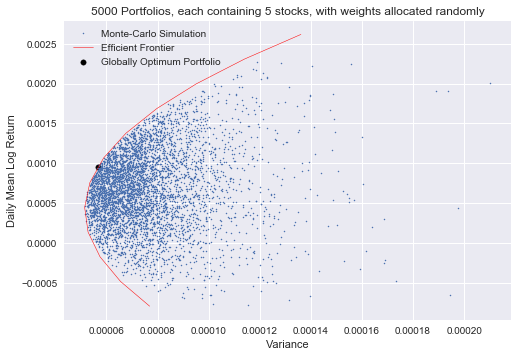

In [36]:
%matplotlib inline
plt.style.use('seaborn')
# Plot Simulation
plt.plot(mc_vars[2:], mc_means[2:], 'o', markersize=1.5)
plt.xlabel('Variance')
plt.ylabel('Daily Mean Log Return')
plt.title(str(n_portfolios) + ' Portfolios, each containing ' + str(N) 
                            + ' stocks, with weights allocated randomly')

# Plot Efficient Frontier
plt.plot(my_vars,my_means,'r',linewidth=0.5) 
plt.scatter([opt_var],[opt_R],30, c='k')
plt.legend(['Monte-Carlo Simulation','Efficient Frontier', 'Globally Optimum Portfolio'])